<a href="https://colab.research.google.com/github/jwalx/Fake-news-detection-using-GNN/blob/main/Master's_Dissertation_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fake News Detections on UPFD

In [ ]:
#Importing Libary
import torch
vers = torch.__version__
print("Torch vers: ", vers)

# PyG installation
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

import torch_geometric

Torch vers:  2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#Downloading the UPFD dataset from pytorch geometric
from torch_geometric.datasets import UPFD
train_data = UPFD(root=".", name="gossipcop", feature="bert", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="bert", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Extracting ./gossipcop/raw/uc
Processing...
Done!


Train Samples:  1092
Test Samples:  3826


In [ ]:
# Checking the edges of the graph
sample_id=1
train_data[sample_id].edge_index

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  15,  15,  17,  17,
          22,  22,  22,  22,  23,  26,  26,  26,  26,  26,  26,  26,  26,  27,
          27,  27,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  30,  34,  34,  38,  38,  38,
          38,  39,  40,  57,  59,  65,  65,  65,  66,  68,  69,  77,  77,  79,
          79,  80,  83,  83,  83,  83,  84, 101, 110, 115, 116, 117],
        [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  43,  44,
          45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  5

In the above output it shows root node that is 0 is connected to many other nodes

0's are basically the first retweets the edges connected to 0 are the additional retweets besed on the orignal retweet

# Converting the datapoints into networkx object and simply use networkx draw function

In [ ]:
!pip install networkx
import networkx as nx

# From PyG utils
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


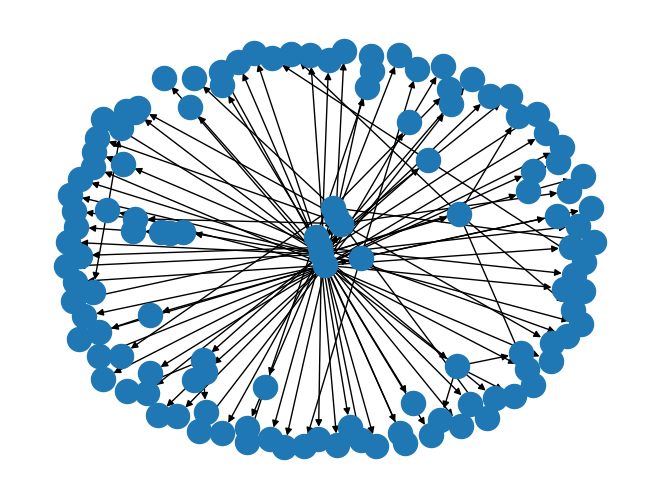

In [ ]:
nx.draw(to_networkx(train_data[sample_id]))

# Node features
its consist 768-dimensional BERT features are encoded using pretrained BERT

In [ ]:
print(train_data[sample_id].x.shape)
train_data[sample_id].x

torch.Size([125, 768])


tensor([[-0.0895, -0.0141, -0.2686,  ...,  0.1738,  0.3480,  0.1831],
        [ 0.0600,  0.0440,  0.0087,  ...,  0.4195,  0.0239,  0.5018],
        [ 0.1362, -0.0738,  0.0080,  ...,  0.3674, -0.1551,  0.3255],
        ...,
        [-0.0284,  0.2227,  0.0766,  ...,  0.5024, -0.0791,  0.7929],
        [-0.0515,  0.1556,  0.2712,  ...,  0.4764,  0.0087,  0.4305],
        [ 0.0070,  0.1475,  0.0915,  ...,  0.5039, -0.0133,  0.6324]])

# Class distribution
Which shows the classes are pretty balanced

<Axes: >

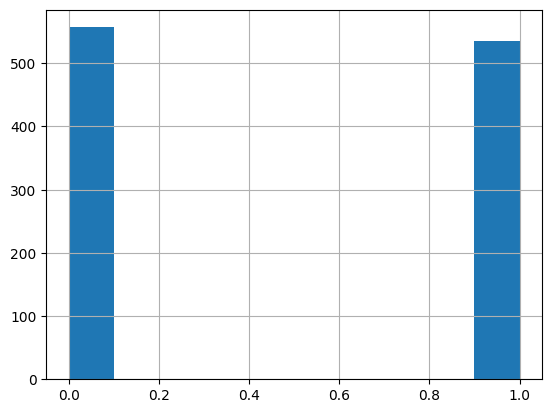

In [ ]:
import pandas as pd
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

# Data Loader

In [ ]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# Creating GNN Model using GATConv layer

The Special part model is instead of using only these embeddings they also used raw language embeddings and concatenated that information so that means we use these pooled graph embeddings and combine them with by inserting raw news articles and we have to perform several operations to achieve this and because we just want the message nodes, and to get the node messages.

In [ ]:
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import SAGEConv,GATConv,GCNConv
from torch.nn import Linear


class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # Graph Convolutions
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        #h = self.conv2(h, edge_index).relu()
        #h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        out = self.lin0(h).relu()

        # According to UPFD paper: Include raw word2vec embeddings of news
        # This is done per graph in the batch
        # we require this step to find the root news node from the retweets

        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)

        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]

        news = self.lin_news(news).relu()

        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 128, 1)


GNN(
  (conv1): SAGEConv(768, 128, aggr=mean)
  (conv2): SAGEConv(128, 128, aggr=mean)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=768, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

# Training

We'll be using Adam Optimizer and for loss function BinaryCross Entropy

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

In [ ]:
for epoch in range(40):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 1.19 | TestLoss: 0.64 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 01 |  TrainLoss: 0.54 | TestLoss: 0.37 | TestAcc: 0.93 | TestF1: 0.94
Epoch: 02 |  TrainLoss: 0.29 | TestLoss: 0.20 | TestAcc: 0.95 | TestF1: 0.95
Epoch: 03 |  TrainLoss: 0.21 | TestLoss: 0.21 | TestAcc: 0.95 | TestF1: 0.95
Epoch: 04 |  TrainLoss: 0.25 | TestLoss: 0.26 | TestAcc: 0.94 | TestF1: 0.95
Epoch: 05 |  TrainLoss: 0.21 | TestLoss: 0.18 | TestAcc: 0.95 | TestF1: 0.95
Epoch: 06 |  TrainLoss: 0.18 | TestLoss: 0.21 | TestAcc: 0.95 | TestF1: 0.96
Epoch: 07 |  TrainLoss: 0.19 | TestLoss: 0.19 | TestAcc: 0.95 | TestF1: 0.95
Epoch: 08 |  TrainLoss: 0.19 | TestLoss: 0.18 | TestAcc: 0.94 | TestF1: 0.94
Epoch: 09 |  TrainLoss: 0.19 | TestLoss: 0.18 | TestAcc: 0.94 | TestF1: 0.94
Epoch: 10 |  TrainLoss: 0.18 | TestLoss: 0.17 | TestAcc: 0.95 | TestF1: 0.95
Epoch: 11 |  TrainLoss: 0.16 | TestLoss: 0.18 | TestAcc: 0.95 | TestF1: 0.95
Epoch: 12 |  TrainLoss: 0.17 | TestLoss: 0.18 | TestAcc: 0.95 | TestF1: 0.96

In [ ]:
print(f'TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

TrainLoss: 0.18 | TestLoss: 0.20 | TestAcc: 0.94 | TestF1: 0.94


# Checking Predictions using the pred logits

In [ ]:
for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.detach().numpy()[:,0]
    df["pred"] = torch.round(pred).detach().numpy()[:,0]
    df["true"] = data.y.numpy()
    print(df.head(10))
    break

   pred_logit  pred  true
0    0.750338   1.0     1
1    0.823520   1.0     1
2    0.000432   0.0     0
3    0.905058   1.0     1
4    0.001869   0.0     0
5    0.000825   0.0     0
6    0.001354   0.0     0
7    0.975286   1.0     1
8    0.001304   0.0     0
9    0.001170   0.0     0


As we can observe most of the predictions are accurate